In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import plotly.express as py
import plotly.graph_objects as go

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Dense, MaxPool2D, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping

#from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras import backend as K
from tensorflow.keras.utils import img_to_array, load_img, array_to_img
from keras.preprocessing.image import ImageDataGenerator

import cv2    

from sklearn.metrics import f1_score

In [3]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [4]:
df_list_attr = pd.read_csv('list_attr_celeba.csv')
df_list_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [5]:
 # Setting 'image_id' column as Index
df_list_attr.replace(to_replace = -1, value = 0,inplace = True ) # Replacing '-1' values for '0', indicating the absence of attributes in the image
df_list_attr.head(10) 

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
5,000006.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,1,1,0,1,0,0,1
6,000007.jpg,1,0,1,1,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,1
7,000008.jpg,1,1,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
8,000009.jpg,0,1,1,0,0,1,1,0,0,...,0,1,0,0,1,0,1,0,0,1
9,000010.jpg,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1


In [6]:
df_list_attr.corr() # to see how our features are correlated.

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
5_o_Clock_Shadow,1.000000,-0.158587,-0.062415,0.168488,0.005584,-0.089243,-0.043699,0.152010,1.006038e-01,-0.132686,...,0.259370,-0.067777,0.052260,-0.124250,-0.161911,0.033997,-0.333921,-0.116239,0.097899,0.014869
Arched_Eyebrows,-0.158587,1.000000,0.250599,-0.091947,-0.069524,-0.027775,0.243400,-0.084025,-9.959764e-04,0.127009,...,-0.116001,0.093834,-0.054486,0.200835,0.294779,-0.099980,0.460409,0.220184,-0.132821,0.146798
Attractive,-0.062415,0.250599,1.000000,-0.178464,-0.145826,0.059712,0.062552,-0.277064,4.139890e-03,0.154774,...,-0.100229,0.147845,0.041550,0.214992,0.124349,-0.138636,0.480104,0.068738,-0.156420,0.387735
Bags_Under_Eyes,0.168488,-0.091947,-0.178464,1.000000,0.116215,-0.057568,-0.005982,0.361604,2.667485e-03,-0.106879,...,0.100411,0.112759,0.024208,-0.127128,-0.096969,-0.005726,-0.284052,-0.052964,0.196980,-0.230759
Bald,0.005584,-0.069524,-0.145826,0.116215,1.000000,-0.064044,-0.003577,0.180148,-8.036419e-02,-0.063056,...,0.058599,0.009402,-0.071920,-0.103482,-0.061211,-0.030625,-0.142852,-0.050445,0.176501,-0.196253
Bangs,-0.089243,-0.027775,0.059712,-0.057568,-0.064044,1.000000,0.034876,-0.069395,-3.355778e-02,0.098854,...,-0.073341,0.052469,0.020034,0.068166,0.058203,-0.079939,0.163378,0.114454,-0.092919,0.017695
Big_Lips,-0.043699,0.243400,0.062552,-0.005982,-0.003577,0.034876,1.000000,0.076814,6.719131e-02,0.023674,...,-0.039739,0.012885,-0.037144,0.120190,0.126523,-0.013286,0.195212,0.149892,-0.067770,0.107722
Big_Nose,0.152010,-0.084025,-0.277064,0.361604,0.180148,-0.069395,0.076814,1.000000,8.109064e-02,-0.158323,...,0.131667,0.100888,-0.028837,-0.131843,-0.058029,0.065552,-0.303651,-0.035930,0.205014,-0.284382
Black_Hair,0.100604,-0.000996,0.004140,0.002667,-0.080364,-0.033558,0.067191,0.081091,1.000000e+00,-0.233626,...,0.043231,-0.002533,0.112496,-0.085227,0.002348,-0.103605,-0.066856,-0.042539,0.023184,0.121372
Blond_Hair,-0.132686,0.127009,0.154774,-0.106879,-0.063056,0.098854,0.023674,-0.158323,-2.336262e-01,1.000000,...,-0.096039,0.090209,0.005458,0.128400,0.095005,-0.083373,0.281935,0.143577,-0.106377,0.052402


In [7]:
attr_names = []
attr_names = list(df_list_attr.columns)
del attr_names[0]
print(attr_names)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [8]:
df_eval_partition = pd.read_csv('list_eval_partition.csv')
df_eval_partition.partition.value_counts()

0    162770
2     19962
1     19867
Name: partition, dtype: int64

In [9]:
attr_to_id = {v:i for i, v in enumerate(attr_names)}
attr_to_id

{'5_o_Clock_Shadow': 0,
 'Arched_Eyebrows': 1,
 'Attractive': 2,
 'Bags_Under_Eyes': 3,
 'Bald': 4,
 'Bangs': 5,
 'Big_Lips': 6,
 'Big_Nose': 7,
 'Black_Hair': 8,
 'Blond_Hair': 9,
 'Blurry': 10,
 'Brown_Hair': 11,
 'Bushy_Eyebrows': 12,
 'Chubby': 13,
 'Double_Chin': 14,
 'Eyeglasses': 15,
 'Goatee': 16,
 'Gray_Hair': 17,
 'Heavy_Makeup': 18,
 'High_Cheekbones': 19,
 'Male': 20,
 'Mouth_Slightly_Open': 21,
 'Mustache': 22,
 'Narrow_Eyes': 23,
 'No_Beard': 24,
 'Oval_Face': 25,
 'Pale_Skin': 26,
 'Pointy_Nose': 27,
 'Receding_Hairline': 28,
 'Rosy_Cheeks': 29,
 'Sideburns': 30,
 'Smiling': 31,
 'Straight_Hair': 32,
 'Wavy_Hair': 33,
 'Wearing_Earrings': 34,
 'Wearing_Hat': 35,
 'Wearing_Lipstick': 36,
 'Wearing_Necklace': 37,
 'Wearing_Necktie': 38,
 'Young': 39}

In [10]:
import cv2

In [11]:
images_path = "img_align_celeba/img_align_celeba/"

In [12]:
df_eval_partition.set_index('image_id', inplace=True)

In [13]:
df_list_attr.set_index('image_id', inplace=True)

In [14]:

df_model = df_eval_partition.join(df_list_attr, how='inner')
df_model.reset_index(inplace=True)

In [15]:
df_model.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,0,1,1,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


# New

In [16]:
BATCH_SIZE = 128
IMG_WIDTH = 228
IMG_HEIGHT = 228
NUM_EPOCHS = 20

In [17]:
def generator(samples_data, batch_size=BATCH_SIZE, shuffle_data=True,IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT):
  
    num_of_samples = len(samples_data)
    while True: 
        samples_data= df_model.sample(frac = 1)
        for offset in range(0, num_of_samples, batch_size):
            batch_of_samples = samples_data.iloc[offset:offset+batch_size, :]
            X_train = []
            y_train = []

            for i in batch_of_samples.index:
              
                img_name = batch_of_samples["image_id"][i]
                label = list(np.array(batch_of_samples[batch_of_samples.index==i].iloc[:, 2:])[0])
                
                img =  cv2.imread('img_align_celeba/img_align_celeba/'+img_name)
                img = cv2.resize(img,(IMG_WIDTH,IMG_HEIGHT))
                
                X_train.append(img)
                y_train.append(label)

            X_train = np.array(X_train)
            y_train = np.array(y_train)

           
            yield X_train, y_train

In [18]:
training_data = df_model.loc[df_model["partition"] == 0]
validation_data = df_model.loc[df_model["partition"] == 1]
testing_data = df_model.loc[df_model["partition"] == 2]

In [19]:
training_data.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,0,1,1,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


In [20]:
len(testing_data)

19962

In [21]:
traing_generator = generator(training_data)
validation_generator = generator(validation_data)
testing_generator = generator(testing_data)
     

In [23]:
train_datagen = ImageDataGenerator(rotation_range=20, 
                                   rescale=1./255,
                                   horizontal_flip=True, 
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)


# data generators:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory=images_path,
    x_col='image_id',
    y_col=attr_names,
    target_size=(228,228),
    batch_size=BATCH_SIZE,
    class_mode='other'
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory=images_path,
    x_col='image_id',
    y_col=attr_names,
    target_size=(228,228),
    batch_size=BATCH_SIZE,
    class_mode='other'
)

--- Logging error ---
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\site-packages\ipykernel_launcher

Found 162770 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\site-packages\ipykernel_launcher

Found 19867 validated image filenames.


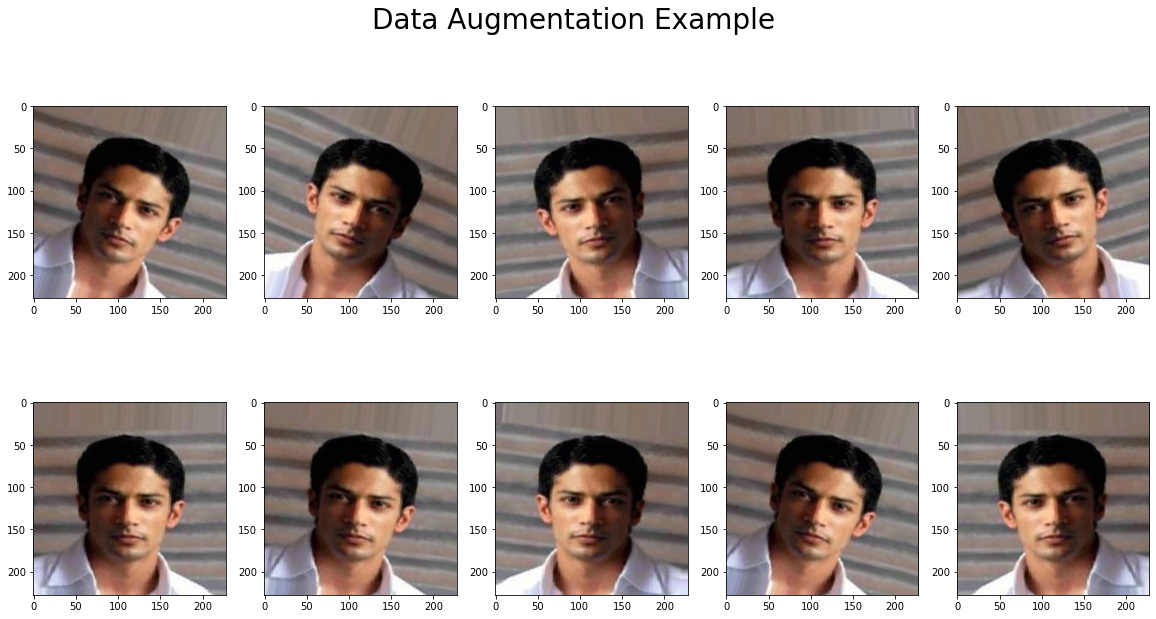

In [28]:
def load_reshape_img(path, shape=(228,228,3)):
  img = load_img(path, target_size=shape)
  x = img_to_array(img) / 255.0
  x = x.reshape((1, ) + x.shape)
  return x


# select and load a picture:
sample_path = os.path.join(images_path + df_model["image_id"][10004])
sample = load_reshape_img(sample_path)

# plot ten augmented images
plt.figure(figsize=(20, 10))
plt.suptitle('Data Augmentation Example', fontsize=28)

for i, image in enumerate(train_datagen.flow(sample, batch_size=1)):
  if i == 10:
    break
    
  plt.subplot(2, 5, i + 1)
  plt.grid(False)
  plt.imshow(image.reshape((228,228,3)) * 255.)

_ = plt.show()

In [29]:
with tf.device(device_name): 
    
  model = Sequential()
  model.add(Conv2D(input_shape=(228,228,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2)))

  model.add(Dropout(0.5))
  

  model.add(Flatten())

  model.add(Dense(units=64,activation="relu"))

  model.add(Dense(units=40, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(0.001)))

  model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics="binary_accuracy")

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 228, 228, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 114, 114, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 114, 114, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 57, 57, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 57, 57, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 57, 57, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0

In [31]:
early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_binary_accuracy", # metrics to monitor
        patience=3, # how many epochs before stop
        verbose=1,
        mode="max", # we need the maximum accuracy.
        restore_best_weights=True, # 
     )

In [32]:
history = model.fit(train_generator, validation_data = valid_generator, steps_per_epoch= training_data.shape[0]//BATCH_SIZE//10, 
                    validation_steps = validation_data.shape[0] // BATCH_SIZE, epochs= NUM_EPOCHS, callbacks=early_stopping, verbose=1)

Epoch 1/20
127/127 [==============================] - 165s 1s/step - loss: 0.4560 - binary_accuracy: 0.8176 - val_loss: 0.4023 - val_binary_accuracy: 0.8421
Epoch 2/20
127/127 [==============================] - 152s 1s/step - loss: 0.3693 - binary_accuracy: 0.8505 - val_loss: 0.3503 - val_binary_accuracy: 0.8599
Epoch 3/20
127/127 [==============================] - 159s 1s/step - loss: 0.3312 - binary_accuracy: 0.8642 - val_loss: 0.3164 - val_binary_accuracy: 0.8705
Epoch 4/20
127/127 [==============================] - 161s 1s/step - loss: 0.3134 - binary_accuracy: 0.8696 - val_loss: 0.2999 - val_binary_accuracy: 0.8768
Epoch 5/20
127/127 [==============================] - 169s 1s/step - loss: 0.2988 - binary_accuracy: 0.8756 - val_loss: 0.2866 - val_binary_accuracy: 0.8819
Epoch 6/20
127/127 [==============================] - 162s 1s/step - loss: 0.2879 - binary_accuracy: 0.8793 - val_loss: 0.2776 - val_binary_accuracy: 0.8857
Epoch 7/20
127/127 [==============================] - 171s

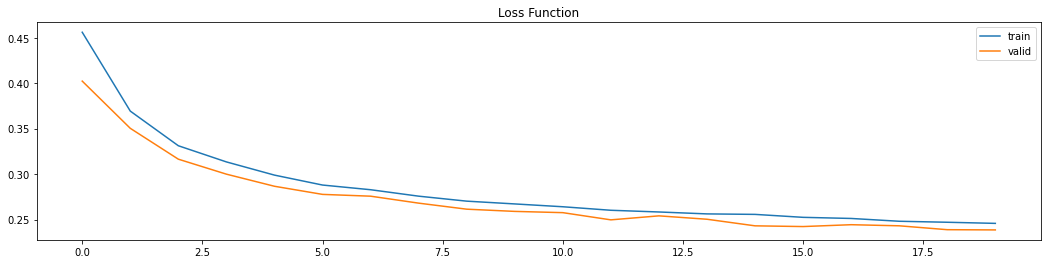

In [33]:

# Plot loss function value through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'valid')
plt.legend()
plt.title('Loss Function')
plt.show()

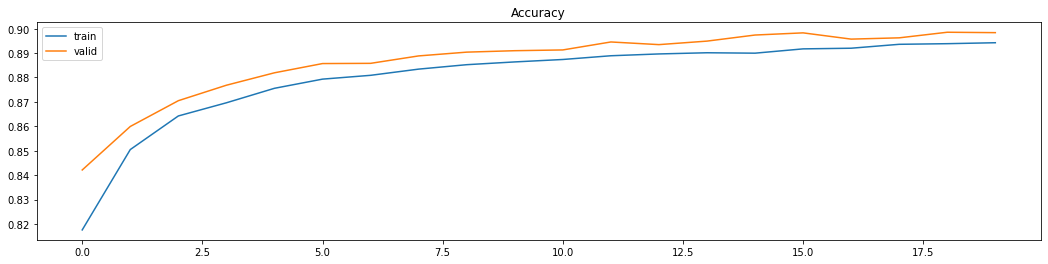

In [34]:

# Plot accuracy through epochs
plt.figure(figsize=(18, 4))
plt.plot(history.history['binary_accuracy'], label = 'train')
plt.plot(history.history['val_binary_accuracy'], label = 'valid')
plt.legend()
plt.title('Accuracy')
plt.show()
     

In [35]:
testing_data.head()

,image_id,partition,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
182637,182638.jpg,2,0,1,0,1,0,0,0,0,...,0,1,0,1,1,1,0,0,0,0
182638,182639.jpg,2,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,1
182639,182640.jpg,2,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
182640,182641.jpg,2,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1
182641,182642.jpg,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1


In [36]:
from sklearn.metrics import accuracy_score

In [39]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_dataframe(
    dataframe=testing_data,
    directory=images_path,
    x_col='image_id',
    y_col=attr_names,
    target_size=(228,228),
    batch_size=BATCH_SIZE,
    class_mode='other'
)


--- Logging error ---
Traceback (most recent call last):
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 1081, in emit
    msg = self.format(record)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 925, in format
    return fmt.format(record)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 664, in format
    record.message = record.getMessage()
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\logging\__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "c:\ProgramData\Anaconda3\envs\tensorflow_2\lib\site-packages\ipykernel_launcher

Found 19962 validated image filenames.


In [37]:
def get_results(testing_data, testing_generator, BATCH_SIZE):
  prediction_list = []
  real_values = []
  for i in range(len(testing_data)//BATCH_SIZE):
    images, labels = next(testing_generator)
    
    # for img, lab in zip(images, labels):
    for pred, true in zip(model.predict(images), labels):
      prediction_list.append(pred)
      real_values.append(true)
  ##############################
  prediction_list = pd.DataFrame(prediction_list)
  prediction_list.columns = list(df_model.head().columns)[2:]
  real_values = pd.DataFrame(real_values)
  real_values.columns = list(df_model.head().columns)[2:]

  for col in prediction_list.columns:
    for index in range(len(prediction_list)):
        if prediction_list[col][index] >= 0.5:
          prediction_list[col][index] = int(1)
        else:
          prediction_list[col][index] = int(0)
  prediction_list = prediction_list.astype(int)

  accuracies = {}
  for col in prediction_list.columns:
    y_true = list(real_values[col])
    y_pred = list(prediction_list[col])
    acc = accuracy_score(y_true, y_pred)
    accuracies[col] = acc
    print("accuracy of "+col+" is : "+str(acc))
  print("**** OVERALL ACCURACY: ", sum(list(accuracies.values()))/len(list(accuracies.values())))

In [40]:
get_results(testing_data, test_generator, BATCH_SIZE)

accuracy of 5_o_Clock_Shadow is : 0.9223790322580645
accuracy of Arched_Eyebrows is : 0.7831149193548387
accuracy of Attractive is : 0.8053427419354838
accuracy of Bags_Under_Eyes is : 0.8337701612903226
accuracy of Bald is : 0.9802923387096775
accuracy of Bangs is : 0.952116935483871
accuracy of Big_Lips is : 0.7094254032258065
accuracy of Big_Nose is : 0.8191028225806452
accuracy of Black_Hair is : 0.8730846774193548
accuracy of Blond_Hair is : 0.9497983870967742
accuracy of Blurry is : 0.9539818548387097
accuracy of Brown_Hair is : 0.8682963709677419
accuracy of Bushy_Eyebrows is : 0.8994959677419355
accuracy of Chubby is : 0.950453629032258
accuracy of Double_Chin is : 0.956804435483871
accuracy of Eyeglasses is : 0.9886592741935484
accuracy of Goatee is : 0.9634072580645161
accuracy of Gray_Hair is : 0.9748487903225806
accuracy of Heavy_Makeup is : 0.8995967741935483
accuracy of High_Cheekbones is : 0.8463709677419354
accuracy of Male is : 0.9585685483870968
accuracy of Mouth_Slig

In [41]:
start = "\033[1m"
end = "\033[0;0m"

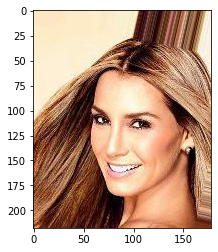

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 1
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 1
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

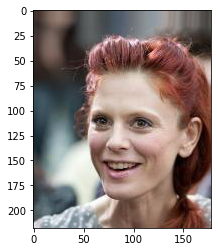

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 1
Bags_Under_Eyes True: 1 Predicted: 1
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

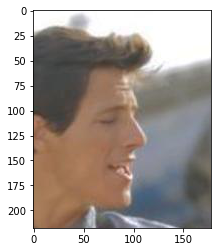

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 1 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

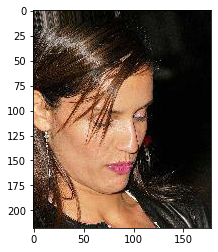

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 1
Big_Lips True: 0 Predicted: 1
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 1
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 1
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

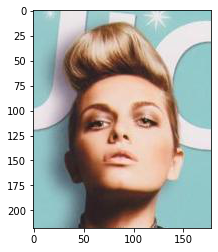

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 1
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 0 Predicted: 0
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 1 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 1
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

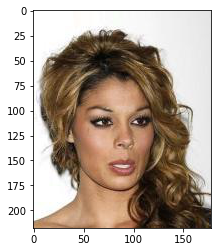

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 1
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 1 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 1
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 0 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

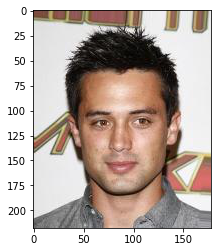

5_o_Clock_Shadow True: 1 Predicted: 1
Arched_Eyebrows True: 0 Predicted: 0
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 1 Predicted: 0
Black_Hair True: 1 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 1 Predicted: 1
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

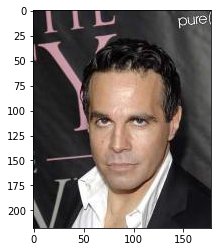

5_o_Clock_Shadow True: 1 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 0
Attractive True: 0 Predicted: 0
Bags_Under_Eyes True: 1 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 1 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 1 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 0 Predicted: 0
High_Cheekbones True: 0 Predicted: 0
Male True: 1 Predicted: 1
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 0
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 0
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

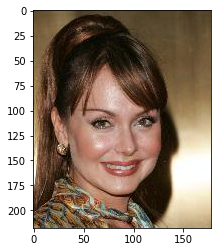

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 1 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 1 Predicted: 1
Big_Lips True: 1 Predicted: 1
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 1
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 1 Predicted: 1
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 1 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 1 Predicted: 1
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 1 Predicted: 1
Sideburns True: 0 Predicted: 0
Sm

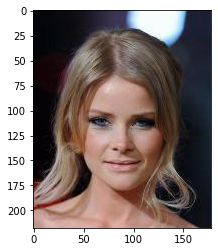

5_o_Clock_Shadow True: 0 Predicted: 0
Arched_Eyebrows True: 0 Predicted: 1
Attractive True: 1 Predicted: 1
Bags_Under_Eyes True: 0 Predicted: 0
Bald True: 0 Predicted: 0
Bangs True: 0 Predicted: 0
Big_Lips True: 0 Predicted: 0
Big_Nose True: 0 Predicted: 0
Black_Hair True: 0 Predicted: 0
Blond_Hair True: 0 Predicted: 0
Blurry True: 0 Predicted: 0
Brown_Hair True: 0 Predicted: 0
Bushy_Eyebrows True: 0 Predicted: 0
Chubby True: 0 Predicted: 0
Double_Chin True: 0 Predicted: 0
Eyeglasses True: 0 Predicted: 0
Goatee True: 0 Predicted: 0
Gray_Hair True: 0 Predicted: 0
Heavy_Makeup True: 1 Predicted: 1
High_Cheekbones True: 1 Predicted: 1
Male True: 0 Predicted: 0
Mouth_Slightly_Open True: 0 Predicted: 0
Mustache True: 0 Predicted: 0
Narrow_Eyes True: 0 Predicted: 0
No_Beard True: 1 Predicted: 1
Oval_Face True: 0 Predicted: 1
Pale_Skin True: 0 Predicted: 0
Pointy_Nose True: 0 Predicted: 1
Receding_Hairline True: 0 Predicted: 0
Rosy_Cheeks True: 0 Predicted: 0
Sideburns True: 0 Predicted: 0
Sm

In [42]:
for img_index in range(10):
  original_img = load_img(images_path + df_model["image_id"][img_index])
  real_values = []
  for col in df_model.columns[2:]:
    real_values.append(df_model[col][img_index])
  img = img_to_array(original_img)
  img = cv2.resize(img,(228,228))
  predictions = model.predict(np.array([img]))
  predictions = list(predictions[0])
  plt.imshow(original_img)
  plt.show()

  for true, pred , col in zip(real_values, predictions, df_model.columns[2:]):
    pred = 1 if pred >=0.5 else 0
    if pred==true:
      print("\033[1;32m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)
    else:
      print("\033[1;31m"+start+col+" True: "+str(true)+ " Predicted: "+str(pred)+end)